# XGBoost on EEG and Spectrogram Data

Two datasets used:
* Raw EEG Data
* Raw Spectrogram Data (NAs filled by 0)

Potential dataset
* Spectrogram data built by EEGs (<a href=https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms/data)>Spectrogram Data Built by Chris Deotte</a>)

Four classes utilized:
* **ReadData**: Simple class to read eeg and spectrogram files
* **FeatureEngineerData**: Class that turns data into summarized statistics
* **EEGFeatures**: Feature engineer EEG data
* **SpectrogramFeatures**: Feature engineer Spectrogram data

In [1]:
import pandas as pd
import numpy as np
from scipy.special import kl_div
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import catboost as cb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('/kaggle/input/kaggle-kl-div/')
from kaggle_kl_div import score

In [2]:
def kld_score(solution, submission):
    '''
    Calculate the average KL divergence score.
    Ignores the "row id" assumed in the first column.
    '''
    sumsum = 0.0
    # Go through the probabilities
    for prob_col in solution.columns.values:
        sumsum += np.nansum(-1.0*solution[prob_col] *
                        np.log(submission[prob_col] / solution[prob_col]))
    return sumsum/(len(solution))

def kl_div_score(model, X_test, true):
    subm = pd.DataFrame(model.predict_proba(X_test), columns = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
    subm = subm.set_axis(true.columns, axis=1)

    subm['id'] = range(len(subm))
    
    true['id'] = range(len(true))
    return score(true, subm, 'id')

class ReadData():
    def __init__(self, is_train = True):
        self.is_train = is_train
    
    def _read_data(self, data_type, file_id):
        if self.is_train:
            PATH = f"/kaggle/input/hms-harmful-brain-activity-classification/train_{data_type}/{file_id}.parquet"
        else:
            PATH = f"/kaggle/input/hms-harmful-brain-activity-classification/test_{data_type}/{file_id}.parquet"
        
        return pd.read_parquet(PATH)
        
    def read_spectrogram_data(self, spectrogram_id):
        return self._read_data('spectrograms', spectrogram_id).set_index('time')
    
    def read_eeg_data(self, eeg_id) -> pd.DataFrame:
        return self._read_data('eegs', eeg_id)
    
    def read_train_data(self):
        return pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
    
    def read_test_data(self):
        return pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")

In [3]:
class FeatureEngineerData(ReadData):
    def __init__(self, metadata, is_train=True, row_id='label_id'):
        '''
        
        Params
        ----------
        metadata : dict
            Contains the information on the eeg ids and labels
        
        '''
        self.metadata = metadata
        self.is_train = is_train
        
        self.row_id = metadata[row_id]    
        
    def get_mean(self, df) -> pd.DataFrame:
        return (df
                .mean()
                .reset_index()
                .set_axis(['var', 'mean'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='mean', index='row_id')
                .add_prefix('mean_')
        )
     
    def get_max(self, df) -> pd.DataFrame:
        return (df
                .max()
                .reset_index()
                .set_axis(['var', 'max'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='max', index='row_id')
                .add_prefix('max_')
        )
    
    def get_min(self, df) -> pd.DataFrame:
        return (df
                .max()
                .reset_index()
                .set_axis(['var', 'min'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='min', index='row_id')
                .add_prefix('min_')
        )   
    
    def get_corr(self, df) -> pd.DataFrame:
        '''
        Returns the correlation of an eeg file
        '''
        def apply_mask(df):
            mask = np.triu(np.ones_like(df, dtype=bool))
            return df.where(mask).unstack().dropna()

        return (df
             .corr()
             .pipe(apply_mask)
             .reset_index()
             .set_axis(['var_1', 'var_2', 'corr'], axis=1)
             .query("var_1 != var_2")
             .assign(
                 row_id = self.row_id,
                 label = lambda x: x.var_1 + "_" + x.var_2
             )
                .pivot(columns='label', values='corr', index='row_id')
                .add_prefix('cor_')
        )
    
    def filter_spectrogram_corr(self, corr_df) -> pd.DataFrame:
        '''
        Returns a dataframe with only the correlation across the same frequency
        '''
        return corr_df[[col for col in corr_df.columns if col.split('_')[2] == col.split('_')[4]]]
    
    def get_std(self, df) -> pd.DataFrame:
        return (df
                .std()
                .reset_index()
                .set_axis(['var', 'std'], axis=1)
                .assign(row_id = self.row_id)
                .pivot(columns='var', values='std', index='row_id')
                .add_prefix('std_')
        )
    
    def get_range(self, df) -> pd.DataFrame:
        return (
            df
            .max()
            .sub(df.min())
            .reset_index()
            .set_axis(['var', 'range'], axis=1)
            .assign(row_id = self.row_id)
            .pivot(columns='var', values='range', index='row_id')
            .add_prefix('range_')
        )
    
    def get_features(self) -> pd.DataFrame:
        
        if self.dataset == 'eeg':
            return (pd.concat([
                self.get_mean(),
                self.get_std(),
                self.get_max(),
                self.get_min(),
                self.get_range(),
                self.get_corr()
            ], axis=1).add_prefix(f"{self.dataset}_{self.timeframe}_"))
        else:
            return (pd.concat([
                self.get_mean(),
                self.get_std(),
                self.get_max(),
                self.get_min()
                #self.filter_spectrogram_corr(self.get_corr())
            ], axis=1).add_prefix(f"{self.dataset}_{self.timeframe}_"))

In [4]:
class EEGFeatures(FeatureEngineerData):
    
    def get_offset(self):
        if self.metadata.get('right_eeg_index') is None:
            return [0, 10000]
        else:
            return [self.metadata['left_eeg_index'], self.metadata['right_eeg_index']]
        
    def format_eeg_data(self, window_sizes = {}):
        
        offset_range = self.get_offset()
        
        df = self.read_eeg_data(self.metadata['eeg_id']).iloc[offset_range[0]:offset_range[1]]
        
        eeg_df = pd.DataFrame()
        for window in window_sizes:
            left_index = window_sizes[window][0]
            right_index = window_sizes[window][1]
            
            eeg_df = pd.concat([
                eeg_df,
                self.get_features(df.iloc[left_index:right_index], time_id = window)
            ], axis=1)
        
        return eeg_df
    
    def get_features(self, df, time_id) -> pd.DataFrame():
        return (
            pd.concat([
                self.get_mean(df),
                self.get_std(df),
                self.get_max(df),
                self.get_range(df),
                self.get_corr(df)
            ], axis=1).add_prefix(f"eeg_{time_id}_")
        )
    
class SpectrogramFeatures(FeatureEngineerData):
    
    def get_offset(self):
        if self.metadata.get('spectrogram_label_offset_seconds') is None:
            return 0
        else:
            return self.metadata['spectrogram_label_offset_seconds']
    
    def format_spectrogram_data(self, window_sizes = {}):
        
        # Create a variable to create the code more readable
        offset = self.get_offset()
        
        # Read specific spectrogram window
        df = (self.read_spectrogram_data(self.metadata['spectrogram_id'])
              .loc[offset:offset+600]
              .fillna(0)
             )
                
        # Creates the middle of the spectrogram
        middle = (offset+(600+offset))/2

        spec_df = pd.DataFrame()
        for window in window_sizes:
            left_index = window_sizes[window][0]
            right_index = window_sizes[window][1]
                        
            spec_df = pd.concat([
                spec_df,
                self.get_features(df.loc[middle+left_index:middle+right_index], time_id = window)
            ], axis=1)
        
        return spec_df
    
    def get_features(self, df, time_id) -> pd.DataFrame():
        return (
            pd.concat([
                self.get_mean(df),
                self.get_std(df),
                self.get_max(df),
                self.get_range(df)
            ], axis=1).add_prefix(f"spec_{time_id}_")
        )

In [5]:
eeg_windows = {
    '10s': (4000, 6000), # Middle 10s
    '30s': (2000, 8000), # Middle 30s
    '50s': (0, 10000), # Entire sample (50s)
}

spec_windows = {
    '10m': (-300, 300),
    '5m': (-150, 150),
    '1m': (-30, 30),
    '10s': (-5, 5),
    '20s': (-10, 10),
    '30s': (-15, 15),
    'pre': (-300, -10),
    'post': (10, 300)
    
}

In [6]:
rd = ReadData()

train_df = rd.read_train_data()
train_df['left_eeg_index'] = train_df['eeg_label_offset_seconds'].multiply(200).astype('int')
train_df['right_eeg_index'] = train_df['eeg_label_offset_seconds'].add(50).multiply(200).astype('int')

In [7]:
df = pd.DataFrame()
for index, row in tqdm(train_df.query("eeg_sub_id == 0").iterrows()):
    e = EEGFeatures(metadata=dict(row))
    s = SpectrogramFeatures(metadata=dict(row))
    
    feature_data = pd.concat([
        e.format_eeg_data(eeg_windows),
        s.format_spectrogram_data(spec_windows)
    ], axis=1)
    
    
    df = pd.concat([
        df,
        feature_data
    ])

0it [00:00, ?it/s]

In [8]:
df = df.sample(frac=1)
df.index.name = 'row_id'

X = df.reset_index(drop=True)
y_prob = df.reset_index().rename(columns={'row_id':'label_id'}).merge(train_df).filter(like = '_vote')
y_prob = y_prob.divide(y_prob.sum(axis=1), axis=0)

TARGETS = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}
y = df.merge(train_df, left_on='row_id', right_on='label_id')['expert_consensus'].map(TARGETS)

patient_id = train_df.query("eeg_sub_id == 0").iloc[0:len(df)].groupby('eeg_id')['patient_id'].first()

In [9]:
folds = GroupKFold(n_splits=4)

for fold, (train_index, valid_index) in enumerate(folds.split(X, y, patient_id)): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index] 
    X_val, y_val = X.iloc[valid_index], y.iloc[valid_index] 

    print('Training: XGB...')
    xgb_mod = xgb.XGBClassifier(
        tree_method="hist", 
        n_estimators = 1000,
        learning_rate=0.1,
        colsample_bytree=1,
        max_depth = 5,
        verbosity=1,
        objective='multi:softmax',
        early_stopping_rounds=20,
        n_jobs=-1
    )
    xgb_mod.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    
    print('KL-Divergence score:', kl_div_score(xgb_mod, X_val, y_prob.iloc[valid_index].reset_index(drop=True)))
    
    print('Training: CatBoost...')
    cb_mod = cb.CatBoostClassifier(
        early_stopping_rounds=20
    )
    
    cb_mod.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    print('KL-Divergence score:', kl_div_score(cb_mod, X_val, y_prob.iloc[valid_index].reset_index(drop=True)))

    break

Training: XGB...
[0]	validation_0-mlogloss:1.70499
[1]	validation_0-mlogloss:1.63148
[2]	validation_0-mlogloss:1.56906
[3]	validation_0-mlogloss:1.51587
[4]	validation_0-mlogloss:1.46879
[5]	validation_0-mlogloss:1.42663
[6]	validation_0-mlogloss:1.38906
[7]	validation_0-mlogloss:1.35621
[8]	validation_0-mlogloss:1.32578
[9]	validation_0-mlogloss:1.29802
[10]	validation_0-mlogloss:1.27321
[11]	validation_0-mlogloss:1.25019
[12]	validation_0-mlogloss:1.22889
[13]	validation_0-mlogloss:1.20909
[14]	validation_0-mlogloss:1.19079
[15]	validation_0-mlogloss:1.17398
[16]	validation_0-mlogloss:1.15814
[17]	validation_0-mlogloss:1.14349
[18]	validation_0-mlogloss:1.13046
[19]	validation_0-mlogloss:1.11687
[20]	validation_0-mlogloss:1.10496
[21]	validation_0-mlogloss:1.09384
[22]	validation_0-mlogloss:1.08311
[23]	validation_0-mlogloss:1.07337
[24]	validation_0-mlogloss:1.06420
[25]	validation_0-mlogloss:1.05541
[26]	validation_0-mlogloss:1.04749
[27]	validation_0-mlogloss:1.03931
[28]	validati

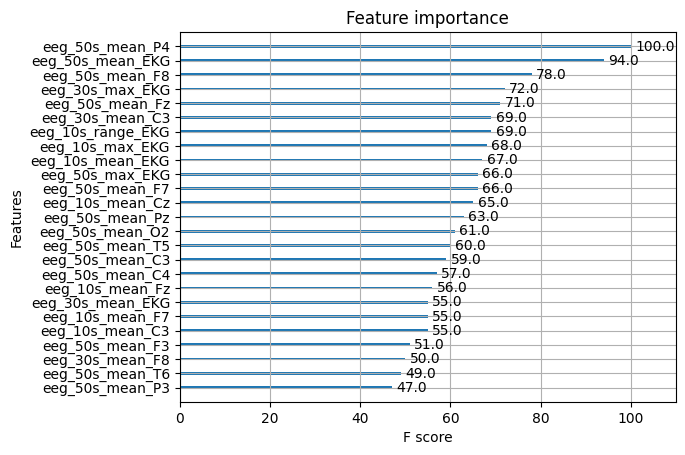

In [10]:
xgb.plot_importance(xgb_mod, max_num_features=25, importance_type='weight')
plt.show()

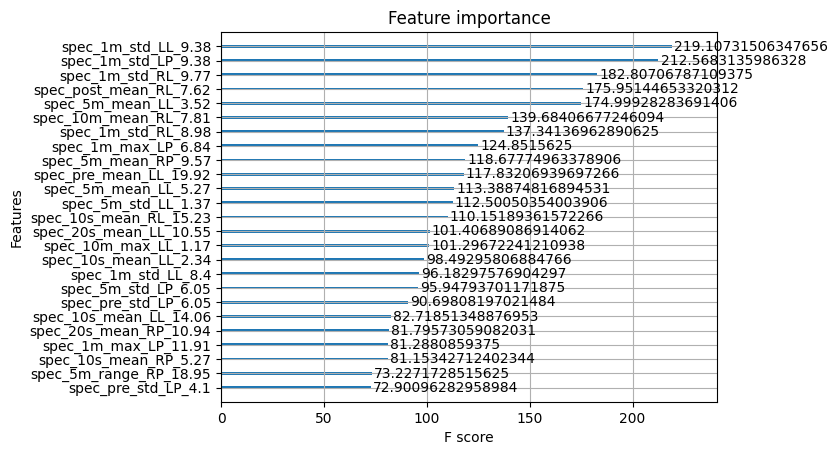

In [11]:
xgb.plot_importance(xgb_mod, max_num_features=25, importance_type='gain')
plt.show()

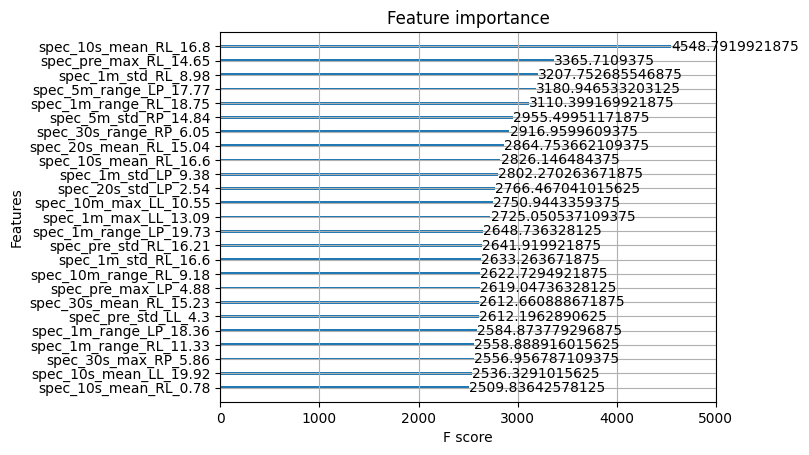

In [12]:
xgb.plot_importance(xgb_mod, max_num_features=25, importance_type='cover')
plt.show()

# Submission

In [13]:
rd = ReadData(is_train=False)

test_df = rd.read_test_data()

In [14]:
X_test = pd.DataFrame()
for index, row in tqdm(test_df.iterrows()):
    e = EEGFeatures(metadata=dict(row), is_train=False, row_id='eeg_id')
    s = SpectrogramFeatures(metadata=dict(row), is_train=False, row_id='eeg_id')
    
    feature_data = pd.concat([
        e.format_eeg_data(eeg_windows),
        s.format_spectrogram_data(spec_windows)
    ], axis=1)
    
    
    X_test = pd.concat([
        X_test,
        feature_data
    ])

0it [00:00, ?it/s]

In [15]:
pred = xgb_mod.predict_proba(X_test)

subm = pd.DataFrame(pred, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
subm['eeg_id'] = test_df.eeg_id

subm[['eeg_id','seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].to_csv("submission.csv", index=False)